In [1]:
# %matplotlib notebook

In [2]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50) #expand all dfs otherwise df with many columsn will be truncated

In [3]:
#import csv data files
# File to Load 
ad_data_to_load = "csv_data/Ad3.csv" #ad data file (only working with 1 of the 3)
cost_of_goods_to_load = "csv_data/cost_of_goods.csv" #cost of goods file
transactions_to_load="csv_data/transactions_main.csv" #transactions file

# Read the csvs
ad_data_raw =pd.read_csv(ad_data_to_load, index_col=False)
cost_of_goods_raw =pd.read_csv(cost_of_goods_to_load)
transactions_raw =pd.read_csv(transactions_to_load)

#create dfs
ad_df_raw = pd.DataFrame(ad_data_raw)
cog_df_raw = pd.DataFrame(cost_of_goods_raw)
trans_df_raw = pd.DataFrame(transactions_raw)

#merge trans df and cost of goods df together on 'sku'
combo_df =pd.merge(trans_df_raw, cog_df_raw, how='inner', on='sku', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

#cog_df_raw.head()
#combo_df.head(3)


In [4]:
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PST", value="") #remove 'PST' from date/time; if PST or PDT remain an error will occur when converting 
combo_df.loc[:, 'date/time'].replace(regex=True,inplace=True,to_replace="PDT", value="") #remove 'PDT' from date/time; if PST or PDT remain an error will occur when converting
combo_df['date/time']=pd.to_datetime(combo_df['date/time']) #converts string date/time to datetime

combo_df.infer_objects() #changes column types. Most are strings or objects and this converts them to floats.  
#combo_df.sort_values('date/time').head() #show new df
combo_df.head(1)


,date/time,settlement id,type,order id,sku,description,quantity,marketplace,fulfillment,order city,order state,order postal,product sales,shipping credits,gift wrap credits,promotional rebates,sales tax collected,Marketplace Facilitator Tax,selling fees,fba fees,other transaction fees,other,total,asin,group,parent,child,est_cost_unit,pick_n_pack_fee
0,2017-02-07 08:23:12,6287999201,Order,S01-3232416-6108561,1I-A550-7LTL,Bamboo Salt Box by Iconic Home,1.0,sim1.stores.amazon.com,Amazon,Lawrence,KS,66049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.5,0.0,0.0,-5.5,B01N5TVYVD,Bamboo Salt Boxes,Bamboo Salt Box,Bamboo Salt Box,0.66,4.18


In [5]:
def trans_cols(x): #creates new cols and their calculations
    x['transaction revenue']= x['total']-x['est_cost_unit']#revenue generate from transaction (revenue - cost of goods)
    x['sale price']= x['product sales']/x['quantity']#generates price of item at sale
    #x['Day of Week']=""  #Mon, Tues, Weds etc...
    x['Cost of Goods']=x['quantity']*x['est_cost_unit'] #total cost of goods for transaction; used to tally reorder amounts
    x['Whole Date'] =pd.to_datetime(combo_df['date/time']).apply(lambda y: y.date()) #converts timestamp to date
    
trans_cols(combo_df) #apply the trans_cols function to create new columns
short_trans_df=combo_df.drop(['settlement id','order id','marketplace','fulfillment'],axis=1) #drop unimportant columns and create a smaller df
short_trans_df.sort_values('date/time').reset_index().head(1) #sort df and reset index to match


,index,date/time,type,sku,description,quantity,order city,order state,order postal,product sales,shipping credits,gift wrap credits,promotional rebates,sales tax collected,Marketplace Facilitator Tax,selling fees,fba fees,other transaction fees,other,total,asin,group,parent,child,est_cost_unit,pick_n_pack_fee,transaction revenue,sale price,Cost of Goods,Whole Date
0,345,2015-04-15 18:48:48,Order,48-JT2Z-XFJ6,Chocolate Disney Frozen Surprise Egg By Zaini-...,1.0,MANDAN,ND,58554-6280,21.99,0.0,3.49,0.0,0.0,0.0,-3.3,-6.16,0.0,0.0,16.02,NaN,NaN,Chocolate Eggs,Frozen Chocolate Eggs,2.31,NaN,13.71,21.99,2.31,2015-04-15


In [6]:
ad_df_raw.head()

,Date,Currency,Campaign Name,Ad Group Name,Advertised SKU,Advertised ASIN,Impressions,Clicks,Click-Thru Rate (CTR),Cost Per Click (CPC),Spend,7 Day Total Sales,Total Advertising Cost of Sales (ACoS),Total Return on Advertising Spend (RoAS),7 Day Total Orders (#),7 Day Total Units (#),7 Day Conversion Rate,7 Day Advertised SKU Units (#),7 Day Other SKU Units (#),7 Day Advertised SKU Sales,7 Day Other SKU Sales
0,5/8/2018,USD,Copper Ant Guard-Qty-3-Auto,Ad Group 1,Ant Guard Qty 3,B0763T3CTK,0,0,NaN,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
1,5/7/2018,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,19,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
2,5/8/2018,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,16,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
3,5/9/2018,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,12,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
4,5/10/2018,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,11,1,9.09%,$0.08,$0.08,$0.00,NaN,0.0,0,0,0.00%,0,0,$0.00,$0.00


In [7]:
ad_data_clean=ad_data_raw
ad_data_clean['Date'] =pd.to_datetime(ad_data_clean['Date']).apply(lambda y: y.date())#converts string date to date
ad_data_clean.head()

,Date,Currency,Campaign Name,Ad Group Name,Advertised SKU,Advertised ASIN,Impressions,Clicks,Click-Thru Rate (CTR),Cost Per Click (CPC),Spend,7 Day Total Sales,Total Advertising Cost of Sales (ACoS),Total Return on Advertising Spend (RoAS),7 Day Total Orders (#),7 Day Total Units (#),7 Day Conversion Rate,7 Day Advertised SKU Units (#),7 Day Other SKU Units (#),7 Day Advertised SKU Sales,7 Day Other SKU Sales
0,2018-05-08,USD,Copper Ant Guard-Qty-3-Auto,Ad Group 1,Ant Guard Qty 3,B0763T3CTK,0,0,NaN,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
1,2018-05-07,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,19,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
2,2018-05-08,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,16,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
3,2018-05-09,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,12,0,0.00%,NaN,$0.00,$0.00,NaN,NaN,0,0,NaN,0,0,$0.00,$0.00
4,2018-05-10,USD,Survival Bracelet-Toggle-Manual-1,Ad Group 1,ZW-OAUA-9YZW,B00WW1H6PC,11,1,9.09%,$0.08,$0.08,$0.00,NaN,0.0,0,0,0.00%,0,0,$0.00,$0.00


In [12]:
#graph test code
def trans_rev(x): #create a df with sum transactions grouped by date
    cols={'Transaction Revenue':x['transaction revenue'].sum()}
    return pd.Series(cols)
p_df=combo_df.groupby('Whole Date').apply(trans_rev)

p_df.reset_index().head()#reset index so "Whole Date" can be used

,Whole Date,Transaction Revenue
0,2015-04-15,13.71
1,2015-04-17,13.71
2,2015-04-18,27.42
3,2015-04-20,41.13
4,2015-04-21,27.42


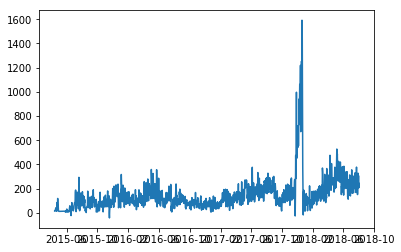

In [13]:
x=p_df.index #must use index, idk why
y=p_df['Transaction Revenue'] 
plt.plot(x, y)

In [10]:
#TODO
#Everyone has repository clone
#Strategy for branching and merging. 
#Outline responsibilities
#


In [2]:
def branch_iss53():
    print('iss53')
    
#another issue 53 change